<center><h1>Analisis de Series Temporales</h1></center>
<center><h2>Lab1</h2></center>
<br>

Fernando Ezequiel Mancuso 


In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
data=pd.read_csv('Telefonia_movil.csv', index_col=['Año', 'Trimestre'])
data.tail()

Minutos pospago salientes (miles)  \
Año  Trimestre                                     
2018 1                                13.423.580   
     2                                14.240.217   
     3                                14.574.305   
     4                                14.915.060   
2019 1                                13.937.271   

                Minutos prepago salientes (miles)  \
Año  Trimestre                                      
2018 1                                    5850985   
     2                                    6027374   
     3                                    6108477   
     4                                    6613685   
2019 1                                    6427084   

                Total de minutos salientes (miles)        Periodo  
Año  Trimestre                                                     
2018 1                                    19274565   Ene-Mar 2018  
     2                                    20267591   Abr-Jun 2018  
     3                                    20682782  Jul-Sept 2018  
     4                                    21528745   Oct-Dic 2018  
2019 1                                    20364355   Ene-Mar 2019

In [5]:
y=data['Total de minutos salientes (miles)']
y

Año   Trimestre
2013  1            15368060
      2            16621329
      3            17650638
      4            16060064
2014  1            15927974
      2            17259534
      3            18703495
      4            19144961
2015  1            16753809
      2            17806395
      3            18965537
      4            19206111
2016  1            17887638
      2            18271759
      3            19001229
      4            22899656
2017  1            20840252
      2            21608730
      3            21414647
      4            19545262
2018  1            19274565
      2            20267591
      3            20682782
      4            21528745
2019  1            20364355
Name: Total de minutos salientes (miles), dtype: int64

## Analisis exploratorio

Graficamos la serie. 

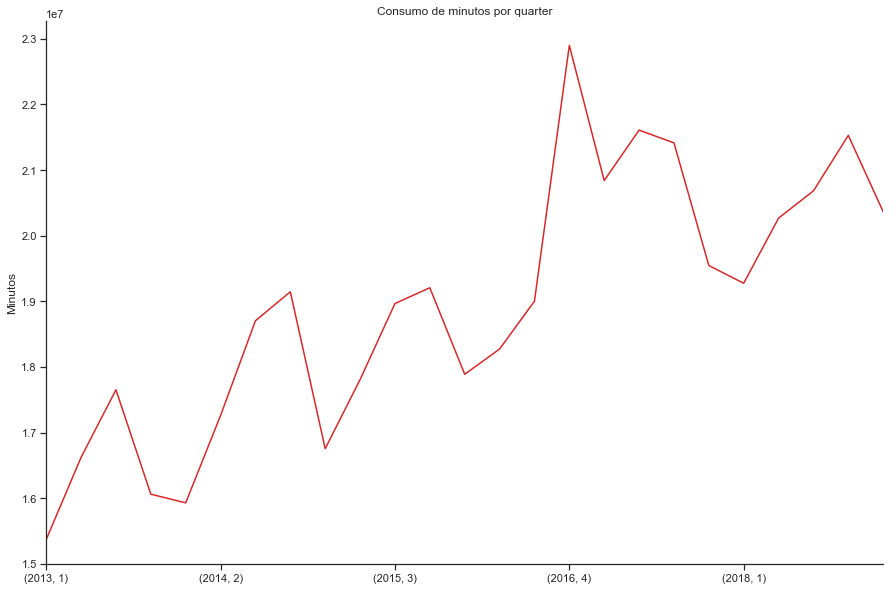

In [6]:
fig, ax= plt.subplots();
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Consumo de minutos por quarter')
sns.despine()
plt.show()

In [7]:
y.describe().round(2)

count          25.00
mean     18922204.72
std       1982378.31
min      15368060.00
25%      17650638.00
50%      19001229.00
75%      20364355.00
max      22899656.00
Name: Total de minutos salientes (miles), dtype: float64

## Random walk 

In [8]:
pred=pd.Series(np.repeat(y.iloc[-1], h))
pred

NameError: name 'h' is not defined

Obtengo la desviacion standard.

In [ ]:
resid=y-y.shift(1)
sigma = resid.std()
round(sigma,3)

In [ ]:
intv = pd.concat([pred-stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1)),
                   pred+stats.norm.ppf(0.975)*sigma*np.sqrt(np.arange(1,h+1))], axis=1)
intv.round(3)

In [ ]:
from plotting import fanchart

point_pred = (intv[0]+intv[1])/2

fig, ax = fanchart(y,point_pred,intv,intv,intv)

plt.show()

## Simple exponential smoothing

In [ ]:
model_ses = sm.tsa.SimpleExpSmoothing(y).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()

Also AIC and BIC looks off so we are continue our analysis with MSE.

In [ ]:
mse_ses = sm.tools.eval_measures.mse(y,fitted_ses)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_ses))

You can calculate AIC and BIC as follows

In [ ]:
N = len(y)
loglik_ses=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses)
aic_ses=-2*loglik_ses+2*3
bic_ses=-2*loglik_ses+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))

Now, let's see how the smoothed data fits the original data

In [ ]:
fig, ax= plt.subplots();#figsize=(9,6))
y.plot(color=red, label='Inflation')
fitted_ses.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [ ]:
resid=y-fitted_ses # model_ses.resid isn't a panda.Series, so no index, no plot

The following cells compute the diagnostics. We find that the residuals are uncorrelated, have non-constant variance (due to higher volatitility in the 80s), and are non-Gaussian. 

In [ ]:
fig, ax= plt.subplots();#figsize=(9,6))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

Next is the residual ACF plot aka correlogram

In [ ]:
fig, ax = plt.subplots();#figsize=(9,6))
sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax)
sns.despine()
plt.show()

Plotting histogram (in blue) and kernel density estimation (in black) for the residuals

In [ ]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid)
plt.show()

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [ ]:
# Real time forecasting - use it as a template - expanding window

validation=y['2004Q1':].index # the validation period is Q1 2004 onwards
start = y.index.get_loc('2004Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

We find that simple exponential smoothing generates more accurate forecasts. 

In [ ]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

## Forecast

We show how to do expanding and rolling point forecast. 

In [ ]:
h=12
w=h*10
data = y
model = sm.tsa.SimpleExpSmoothing
pred_index = y.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast